In [5]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [140]:
class CommNet:
    
    def __init__(self, sess, N, J, embedding_size = 128, lr = 1e-3, training_mode = 'supervised', gamma = 1):
        
        self.N = N
        self.J = J
        self.embedding_size = embedding_size
        
        self.build_controler()
        
        self.training_mode = training_mode
        
        if training_mode == 'supervised':
            self.build_supervised()
            with tf.variable_scope('Supervised_optimizer'):
                self.train_op = tf.train.AdamOptimizer(lr).minimize(self.supervised_loss)
                
        elif training_mode == 'reinforce':
            self.gamma = gamma
            self.build_reinforce()
            with tf.variable_scope('Reinforce_optimizer'):
                self.train_op =  tf.train.AdamOptimizer(lr).minimize(self.reinforce_loss)
            
        else:
            raise(ValueError("Unknown training mode: %s" % training_mode))
        
        print("All variables")
        for var in tf.global_variables():
            print(var)
            
        
        self.sess = sess
        self.sess.run(tf.global_variables_initializer())
        
    def encode(self, inputs):
        
        with tf.variable_scope('Encoder'):
        
            identity_embeddings = tf.get_variable("identity_embeddings",
                                             [self.N, self.embedding_size])
            
            embedded_identities = tf.nn.embedding_lookup(identity_embeddings, inputs)
            
        return tf.unstack(embedded_identities, axis = 1)
    
    def build_f(self, name, h, c, h0 = None):
        
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            
            if h0 is not None:
                
                W1 = tf.get_variable('W1', shape = (3 * self.embedding_size,
                                                  self.embedding_size))
                
                concat = tf.concat([h, c, h0], axis = 1)
            
            else:
                W1 = tf.get_variable('W1', shape = (2 * self.embedding_size,
                                                  self.embedding_size))
                
                concat = tf.concat([h, c], axis = 1)
            
            W2 = tf.get_variable('W2', shape = (self.embedding_size,
                                                  self.embedding_size))
            
            dense1 =  tf.nn.relu(tf.einsum("ij,jk->ik", concat, W1))
            dense2 = tf.nn.relu(tf.einsum("ij,jk->ik", dense1, W2))
            
            return dense2
        
    def decode(self, h):
        
        with tf.variable_scope('Decoder', reuse = tf.AUTO_REUSE):
            
            W = tf.get_variable('W', shape = (self.embedding_size,
                                                  self.J))
            
            policy_logit = tf.einsum("ij,jk->ik", h, W)
        
            return policy_logit
    
    
    def communicate(self, h_seq):
        
        return tf.add_n(h_seq) / (self.J - 1)
    
    def sample_actions(self, policy_logit):
        
        
        action = tf.multinomial(policy_logit, num_samples = 1)
        
        return action
    
        
    def build_controler(self):
        
        self.inputs = tf.placeholder(tf.int32, shape = (None, self.J))
        
        h0_seq = self.encode(self.inputs)
        c0_seq = [self.communicate([h0_seq[j] for j in range(self.J) if j != i]) for i in range(self.J)]
        
        h1_seq = [self.build_f("Comm_step_1", h0_seq[j], c0_seq[j], None) for j in range(self.J)]
        c1_seq = [self.communicate([h1_seq[j] for j in range(self.J) if j != i]) for i in range(self.J)]
        
        h2_seq = [self.build_f("Comm_step_2", h1_seq[j], c1_seq[j], h0_seq[j]) for j in range(self.J)]
        
        
        self.policy_logit_seq = [self.decode(h2) for h2 in h2_seq]
        
        self.action_seq = [self.sample_actions(policy_logit) for policy_logit in self.policy_logit_seq]
        
        
        
    def build_supervised(self):
        
        assert self.training_mode == 'supervised', 'Wrong training mode'
        
        self.one_hot_action_seq = [tf.one_hot(tf.reshape(action, [-1]), depth = self.J) for action in self.action_seq]
        self.targets = tf.placeholder(tf.int32, shape = (None, self.J))
        unstacked_targets = tf.unstack(self.targets, axis = 1)
        
        supervised_loss_seq = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_targets[j],
                                                                                   logits=self.policy_logit_seq[j])
                                    for j in range(self.J)]
        
        self.supervised_loss = tf.reduce_sum(tf.add_n(supervised_loss_seq))
        
        
        
    def supervised_train(self, X, y, val_X, val_y, env, batch_size = 32, epochs = 1):
        
        assert self.training_mode == 'supervised', 'Wrong training mode'
        
        n = X.shape[0]
        
        val_n = val_X.shape[0]
        
        data_inds = np.array(range(n))
        for ep in range(1, epochs + 1):
            np.random.shuffle(data_inds)
            supervised_loss_sum = 0
            reward_sum = 0
            for i in tqdm(range(0, n, batch_size), "Epoch: %d" % ep):
                inds_batch = data_inds[i:i+batch_size]
                X_batch = X[inds_batch]
                y_batch = y[inds_batch]
                _, supervised_loss, one_hot_action_seq = sess.run([self.train_op, self.supervised_loss, self.one_hot_action_seq], feed_dict={self.inputs: X_batch, self.targets: y_batch})
                supervised_loss_sum += supervised_loss
                reward_sum += env.get_reward(one_hot_action_seq)
            
            print("loss = %f" % (supervised_loss_sum / n))
            print("reward = %f" % (reward_sum / n))
            print()
            
            val_supervised_loss, val_one_hot_action_seq = sess.run([self.supervised_loss, self.one_hot_action_seq], feed_dict={self.inputs: val_X, self.targets: val_y})
            print('val loss = %f' % (val_supervised_loss / val_n))
            print('val reward = %f' % (env.get_reward(val_one_hot_action_seq) / val_n))
            

    def build_reinforce(self):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        self.advantage = tf.placeholder(tf.float32)
  
        
        self.action_taken = tf.placeholder(tf.int32, shape = (None, self.J))
        unstacked_action_taken = tf.unstack(self.action_taken, axis = 1)
        
        self.neg_log_p_seq = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_action_taken[j],
                                                    logits=self.policy_logit_seq[j]) for j in range(self.J)]
        #surrogate loss
        self.reinforce_loss =  tf.add_n([tf.reduce_mean(tf.multiply(self.advantage, self.neg_log_p_seq[j]), axis = 0) for j in range(self.J)])
        
    def take_action(self, state):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        action_seq= self.sess.run(self.action_seq, {self.inputs: [state]})
        
        return [x[0,0] for x in action_seq]
    
    def reinforce_train(self, env, n_episodes, T):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        baseline = np.zeros(self.N)
        
        discount_factors = np.array([self.gamma ** t for t in range(T)])
        
        history = {'reward' : [],  'loss': []}
    
        
        for _ in tqdm(range(n_episodes), "REINFORCE"):
            
            # todo: change code to avoid this seq_seq name (sequence of sequence)
            state_seq, action_seq, reward_seq = policy_rollout(T, env, commNet)
            t = reward_seq.shape[0]
            G = np.sum(reward_seq * discount_factors[:t])
            
            history['reward'].append(np.mean(reward_seq))
            
            feed_dict = {}
            feed_dict[self.inputs] = state_seq
            feed_dict[self.advantage] = G - np.asscalar(np.sum(baseline[state_seq]) / self.J)
            feed_dict[self.action_taken] = action_seq
            
            _, loss = self.sess.run([self.train_op, self.reinforce_loss], feed_dict = feed_dict)
            
            history['loss'].append(loss)
            
            # update baseline
            raveled_state_seq = state_seq.ravel()
            repeated_reward_seq = np.repeat(reward_seq, self.J)
            distinct_states = list(set(raveled_state_seq))
            state_count = np.zeros(self.N)
            reward_sum = np.zeros(self.N)
            
            for s,r in zip(raveled_state_seq, repeated_reward_seq):
                state_count[s] += 1
                reward_sum[s] += r
            baseline[distinct_states] = 0.99 * baseline[distinct_states] + 0.01 * reward_sum[distinct_states]/state_count[distinct_states]
        print(baseline)
        return history
            
            
            
            
            
            
            
        

In [141]:
class LeverEnv:
    
    def __init__(self, N, J):
        
        self.J = J
        self.N = N
        
    def reset(self):
        
        state = np.sort(np.random.choice(self.N, size = self.J, replace = False))
        
        terminal_state = False
        
        return state, terminal_state        
    
    def get_reward(self, one_hot_action_seq):        
        
        reward = np.sum(np.sum(one_hot_action_seq, axis = 0) > 0) /self.J
        
        return reward
        
    def step(self, state, action):
        
        next_state = np.sort(np.random.choice(self.N, size = self.J, replace = False))
        
        one_hot_action_seq = np.zeros((self.J, self.J))
        one_hot_action_seq[range(self.J), action] = 1
        reward = self.get_reward(one_hot_action_seq)
        
        terminal_state = False
        
        return next_state, reward, terminal_state
        

In [142]:
# data generation for supervised learning
def generate_data(n, N, J):
    
    X = np.empty((n, J), dtype = int)
    
    for i in range(n):
        
        X[i] = np.sort(np.random.choice(N, size = J, replace = False))
        
    y = np.tile([j for j in range(J)], (n,1))
        
    return X, y

In [143]:
# episode generation for reinforcement learning
def policy_rollout(T, env, agent):
    
    state_seq = []
    action_seq = []
    reward_seq = []
    
    
    state, terminal_state = env.reset()
    
    t = 0
    
    while not terminal_state and t < T:
        t +=1
        
        state_seq.append(state)
        action = agent.take_action(state)
        
        state, reward, terminal_state = env.step(state, action)
        
        
        action_seq.append(action)
        reward_seq.append(reward)
        
    return np.array(state_seq), np.array(action_seq), np.array(reward_seq)

In [144]:
N = 100
J = 5
batch_size = 32
n = batch_size * 1000

In [145]:
X, y = generate_data(n, N, J)
val_X, val_y = generate_data(1024, N, J)

In [146]:
tf.reset_default_graph()
with tf.Session() as sess:
    commNet = CommNet(sess, N, J, lr = 1e-4, training_mode = 'reinforce')
    env = LeverEnv(N, J)
    #commNet.supervised_train(X, y, val_X, val_y, env, batch_size = batch_size, epochs = 10)
    
    history = commNet.reinforce_train(env, n_episodes = 3000, T = 3)

    
    state_seq, action_seq, reward_seq = policy_rollout(3, env, commNet)
    
    print(state_seq)
    print(action_seq)
    print(reward_seq)
    G = np.sum(reward_seq)
    print(G)
    
    feed_dict = {}
    feed_dict[commNet.inputs] = state_seq
    feed_dict[commNet.advantage] = G * np.ones((3, J))
    feed_dict[commNet.action_taken] = action_seq

    commNet.sess.run(commNet.train_op, feed_dict = feed_dict)
    
    rv = sess.run([commNet.policy_logit_seq, commNet.neg_log_p_seq, commNet.reinforce_loss, commNet.policy_logit_seq], feed_dict= feed_dict)
    

All variables
<tf.Variable 'Encoder/identity_embeddings:0' shape=(100, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/W1:0' shape=(256, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/W2:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/W1:0' shape=(384, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/W2:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Decoder/W:0' shape=(128, 5) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Encoder/identity_embeddings/Adam:0' shape=(100, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Encoder/identity_embeddings/Adam_1:0' shape=(100, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Comm_step_1/W1/Adam:0' shape=(256, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Comm_step_1/W1/Adam_1:0' shape=(256, 128) dtype=float32_ref>
<tf.Variable 'Re


REINFORCE:  23%|███████████████▍                                                    | 682/3000 [00:08<00:27, 85.80it/s]


REINFORCE:  43%|████████████████████████████▉                                      | 1298/3000 [00:15<00:22, 76.99it/s]


REINFORCE:  61%|████████████████████████████████████████▌                          | 1819/3000 [00:23<00:15, 78.44it/s]


REINFORCE:  81%|██████████████████████████████████████████████████████▌            | 2441/3000 [00:30<00:06, 91.13it/s]


REINFORCE:  99%|██████████████████████████████████████████████████████████████████▎| 2971/3000 [00:38<00:00, 78.40it/s]


REINFORCE: 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [00:38<00:00, 77.36it/s]

[0.66613618 0.65356245 0.6700509  0.64337436 0.65729369 0.6779152
 0.67605325 0.67198194 0.66974641 0.66136806 0.66353669 0.66767292
 0.68677558 0.66715002 0.66225542 0.66791094 0.65318314 0.6544261
 0.6680793  0.66377774 0.65604758 0.66321849 0.67067661 0.67017238
 0.67088948 0.66314334 0.67586486 0.66244577 0.65390976 0.6585408
 0.66418373 0.67351741 0.66033265 0.67503141 0.6492138  0.6442113
 0.66858291 0.67365825 0.66954155 0.66035627 0.66769085 0.67347189
 0.65771324 0.66258936 0.66399309 0.67354099 0.6617599  0.66018461
 0.66483392 0.641309   0.65292416 0.66447076 0.66877894 0.68283197
 0.66102454 0.66892368 0.66455842 0.67234267 0.66703561 0.65643331
 0.65970298 0.65262312 0.67132907 0.68373242 0.65492089 0.68022717
 0.64999668 0.65668401 0.67263598 0.66223933 0.66446792 0.65754683
 0.65936926 0.68220805 0.66374173 0.67112368 0.64526176 0.66731092
 0.65404231 0.66037482 0.65614277 0.66462048 0.67850379 0.6571483
 0.6602023  0.67998981 0.67124287 0.65242624 0.64880415 0.66286571


InvalidArgumentError: Incompatible shapes: [3,5] vs. [3]
	 [[node Reinforce_optimizer/gradients/Mul_grad/BroadcastGradientArgs (defined at <ipython-input-140-47d70013f3ac>:22)  = BroadcastGradientArgs[T=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Reinforce_optimizer/gradients/Mul_3_grad/Shape, Reinforce_optimizer/gradients/Mul_grad/Shape_1)]]

Caused by op 'Reinforce_optimizer/gradients/Mul_grad/BroadcastGradientArgs', defined at:
  File "C:\Users\Romain Zimmer\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-146-4852bcfd72b3>", line 3, in <module>
    commNet = CommNet(sess, N, J, lr = 1e-4, training_mode = 'reinforce')
  File "<ipython-input-140-47d70013f3ac>", line 22, in __init__
    self.train_op =  tf.train.AdamOptimizer(lr).minimize(self.reinforce_loss)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 400, in minimize
    grad_loss=grad_loss)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 519, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 630, in gradients
    gate_gradients, aggregation_method, stop_gradients)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 814, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 408, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 814, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py", line 940, in _MulGrad
    rx, ry = gen_array_ops.broadcast_gradient_args(sx, sy)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 675, in broadcast_gradient_args
    "BroadcastGradientArgs", s0=s0, s1=s1, name=name)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

...which was originally created as op 'Mul', defined at:
  File "C:\Users\Romain Zimmer\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 19 identical lines from previous traceback]
  File "<ipython-input-146-4852bcfd72b3>", line 3, in <module>
    commNet = CommNet(sess, N, J, lr = 1e-4, training_mode = 'reinforce')
  File "<ipython-input-140-47d70013f3ac>", line 20, in __init__
    self.build_reinforce()
  File "<ipython-input-140-47d70013f3ac>", line 175, in build_reinforce
    self.reinforce_loss =  tf.add_n([tf.reduce_mean(tf.multiply(self.advantage, self.neg_log_p_seq[j]), axis = 0) for j in range(self.J)])
  File "<ipython-input-140-47d70013f3ac>", line 175, in <listcomp>
    self.reinforce_loss =  tf.add_n([tf.reduce_mean(tf.multiply(self.advantage, self.neg_log_p_seq[j]), axis = 0) for j in range(self.J)])
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 203, in multiply
    return gen_math_ops.mul(x, y, name)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 5041, in mul
    "Mul", x=x, y=y, name=name)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [3,5] vs. [3]
	 [[node Reinforce_optimizer/gradients/Mul_grad/BroadcastGradientArgs (defined at <ipython-input-140-47d70013f3ac>:22)  = BroadcastGradientArgs[T=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Reinforce_optimizer/gradients/Mul_3_grad/Shape, Reinforce_optimizer/gradients/Mul_grad/Shape_1)]]


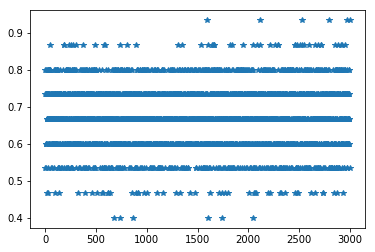

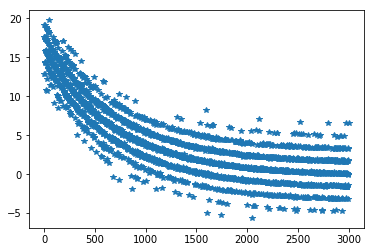

In [147]:
plt.plot(history['reward'], '*')
plt.show()
plt.plot(history['loss'], '*')
plt.show()

In [ ]:
rv[0]

In [199]:
rv[1]

[array([0., 0., 0.], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([0., 0., 0.], dtype=float32)]

In [200]:
rv[2]

0.0

In [201]:
rv[3]

[array([[ 105.13341 ,  -27.344757,  -22.029278,  -97.396484,  -38.40857 ],
        [  59.349194,  -15.48696 ,  -13.95987 ,  -54.110474,  -18.848036],
        [ 153.63214 ,  -40.30889 ,  -31.816639, -142.6672  ,  -56.442955]],
       dtype=float32),
 array([[ 110.14528 ,  -28.897942,  -22.149921, -102.49854 ,  -41.06072 ],
        [  50.561512,  -13.201023,  -11.430093,  -46.29268 ,  -17.780636],
        [ 134.92569 ,  -35.47708 ,  -28.584341, -125.3229  ,  -49.612938]],
       dtype=float32),
 array([[ 104.164024,  -26.65059 ,  -23.32068 ,  -95.45499 ,  -35.965065],
        [  58.250057,  -15.278679,  -12.216818,  -53.61756 ,  -20.954084],
        [ 125.37193 ,  -32.170273,  -27.278997, -115.82131 ,  -44.955193]],
       dtype=float32),
 array([[ 120.78745 ,  -32.132336,  -23.994822, -112.20073 ,  -44.916557],
        [  58.981075,  -15.748252,  -12.847244,  -54.7952  ,  -21.025501],
        [ 143.18594 ,  -38.1636  ,  -28.778002, -133.8264  ,  -53.82146 ]],
       dtype=float32),
 arr